In [1]:
import os
os.add_dll_directory("C:/Users/manub/Desktop/Projects/thundersvm/build/bin/Release")

<AddedDllDirectory('C:/Users/manub/Desktop/Projects/thundersvm/build/bin/Release')>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [3]:
# Set random seeds to ensure that the results are repeatable with each run.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
# Check if cuda is available
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('CUDA is available. Using GPU.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU.')

CUDA is available. Using GPU.


In [5]:
# Import Dataset
all_data = pd.read_excel("../data/CustomerChurn.xlsx")
# Remove the customer ID labels
all_data.drop(["LoyaltyID", "Customer ID"], axis = 1, inplace = True)
# Display the data
all_data.head()

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     7043 non-null   object 
 1   Partner            7043 non-null   object 
 2   Dependents         7043 non-null   object 
 3   Tenure             7043 non-null   int64  
 4   Phone Service      7043 non-null   object 
 5   Multiple Lines     7043 non-null   object 
 6   Internet Service   7043 non-null   object 
 7   Online Security    7043 non-null   object 
 8   Online Backup      7043 non-null   object 
 9   Device Protection  7043 non-null   object 
 10  Tech Support       7043 non-null   object 
 11  Streaming TV       7043 non-null   object 
 12  Streaming Movies   7043 non-null   object 
 13  Contract           7043 non-null   object 
 14  Paperless Billing  7043 non-null   object 
 15  Payment Method     7043 non-null   object 
 16  Monthly Charges    7043 

In [7]:
sum(all_data["Total Charges"] == ' ')

11

In [8]:
all_data[all_data["Total Charges"] == " "]

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


There's 11 of the above... let's just get rid of them.

In [9]:
all_data.drop(all_data[all_data["Total Charges"] == " "].index, inplace = True)
all_data.reset_index(drop = True, inplace = True)
sum(all_data["Total Charges"] == ' ')

0

In [10]:
all_data["Total Charges"] = all_data["Total Charges"].astype(float)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     7032 non-null   object 
 1   Partner            7032 non-null   object 
 2   Dependents         7032 non-null   object 
 3   Tenure             7032 non-null   int64  
 4   Phone Service      7032 non-null   object 
 5   Multiple Lines     7032 non-null   object 
 6   Internet Service   7032 non-null   object 
 7   Online Security    7032 non-null   object 
 8   Online Backup      7032 non-null   object 
 9   Device Protection  7032 non-null   object 
 10  Tech Support       7032 non-null   object 
 11  Streaming TV       7032 non-null   object 
 12  Streaming Movies   7032 non-null   object 
 13  Contract           7032 non-null   object 
 14  Paperless Billing  7032 non-null   object 
 15  Payment Method     7032 non-null   object 
 16  Monthly Charges    7032 

In [11]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        print("------------")
        print(all_data[col].value_counts())

------------
Senior Citizen
No     5890
Yes    1142
Name: count, dtype: int64
------------
Partner
No     3639
Yes    3393
Name: count, dtype: int64
------------
Dependents
No     4933
Yes    2099
Name: count, dtype: int64
------------
Phone Service
Yes    6352
No      680
Name: count, dtype: int64
------------
Multiple Lines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64
------------
Internet Service
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64
------------
Online Security
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64
------------
Online Backup
No                     3087
Yes                    2425
No internet service    1520
Name: count, dtype: int64
------------
Device Protection
No                     3094
Yes                    2418
No internet service    1520
Name: count, dtype: int64
------------
Tech Support
No          

The values "No internet service" and "No phone service" in certain columns are because of a respective value in another column within the same dataset. These values do not need to be represented. However, the columns that they are in are otherwise Yes/No columns that can be turned into binary. These values can be removed by turning them into "No".

In [12]:
# Remove the impresent phrases within the dataframe
all_data = all_data.replace(["No internet service", "No phone service"], "No")

In [13]:
# Before proceeding, we need to turn all the object values into int
for col in all_data.columns:
    # We can start by changing Yes/No into True/False
    if all_data[col].nunique() == 2:
        all_data[col] = all_data[col].replace({'Yes': True, 'No': False})
    

C:\Users\manub\AppData\Local\Temp\ipykernel_38732\999685621.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data[col] = all_data[col].replace({'Yes': True, 'No': False})


In [14]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        print("------------")
        print(col)
        print(all_data[col].unique())

------------
Internet Service
['DSL' 'Fiber optic' 'No']
------------
Contract
['Month-to-month' 'One year' 'Two year']
------------
Payment Method
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [15]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     7032 non-null   bool   
 1   Partner            7032 non-null   bool   
 2   Dependents         7032 non-null   bool   
 3   Tenure             7032 non-null   int64  
 4   Phone Service      7032 non-null   bool   
 5   Multiple Lines     7032 non-null   bool   
 6   Internet Service   7032 non-null   object 
 7   Online Security    7032 non-null   bool   
 8   Online Backup      7032 non-null   bool   
 9   Device Protection  7032 non-null   bool   
 10  Tech Support       7032 non-null   bool   
 11  Streaming TV       7032 non-null   bool   
 12  Streaming Movies   7032 non-null   bool   
 13  Contract           7032 non-null   object 
 14  Paperless Billing  7032 non-null   bool   
 15  Payment Method     7032 non-null   object 
 16  Monthly Charges    7032 

The only object columns left are Internet Service, Contract, and Payment Method. These can be one-hot encoded. 

In [16]:
onehotcols = ["Internet Service", "Contract", "Payment Method"]

# Get the dummies of these ones
df = pd.get_dummies(all_data, columns=onehotcols, drop_first=False)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Senior Citizen                            7032 non-null   bool   
 1   Partner                                   7032 non-null   bool   
 2   Dependents                                7032 non-null   bool   
 3   Tenure                                    7032 non-null   int64  
 4   Phone Service                             7032 non-null   bool   
 5   Multiple Lines                            7032 non-null   bool   
 6   Online Security                           7032 non-null   bool   
 7   Online Backup                             7032 non-null   bool   
 8   Device Protection                         7032 non-null   bool   
 9   Tech Support                              7032 non-null   bool   
 10  Streaming TV                        

In [18]:
# Save the data
df.to_csv("../data/bs_eda.csv")

# EDA

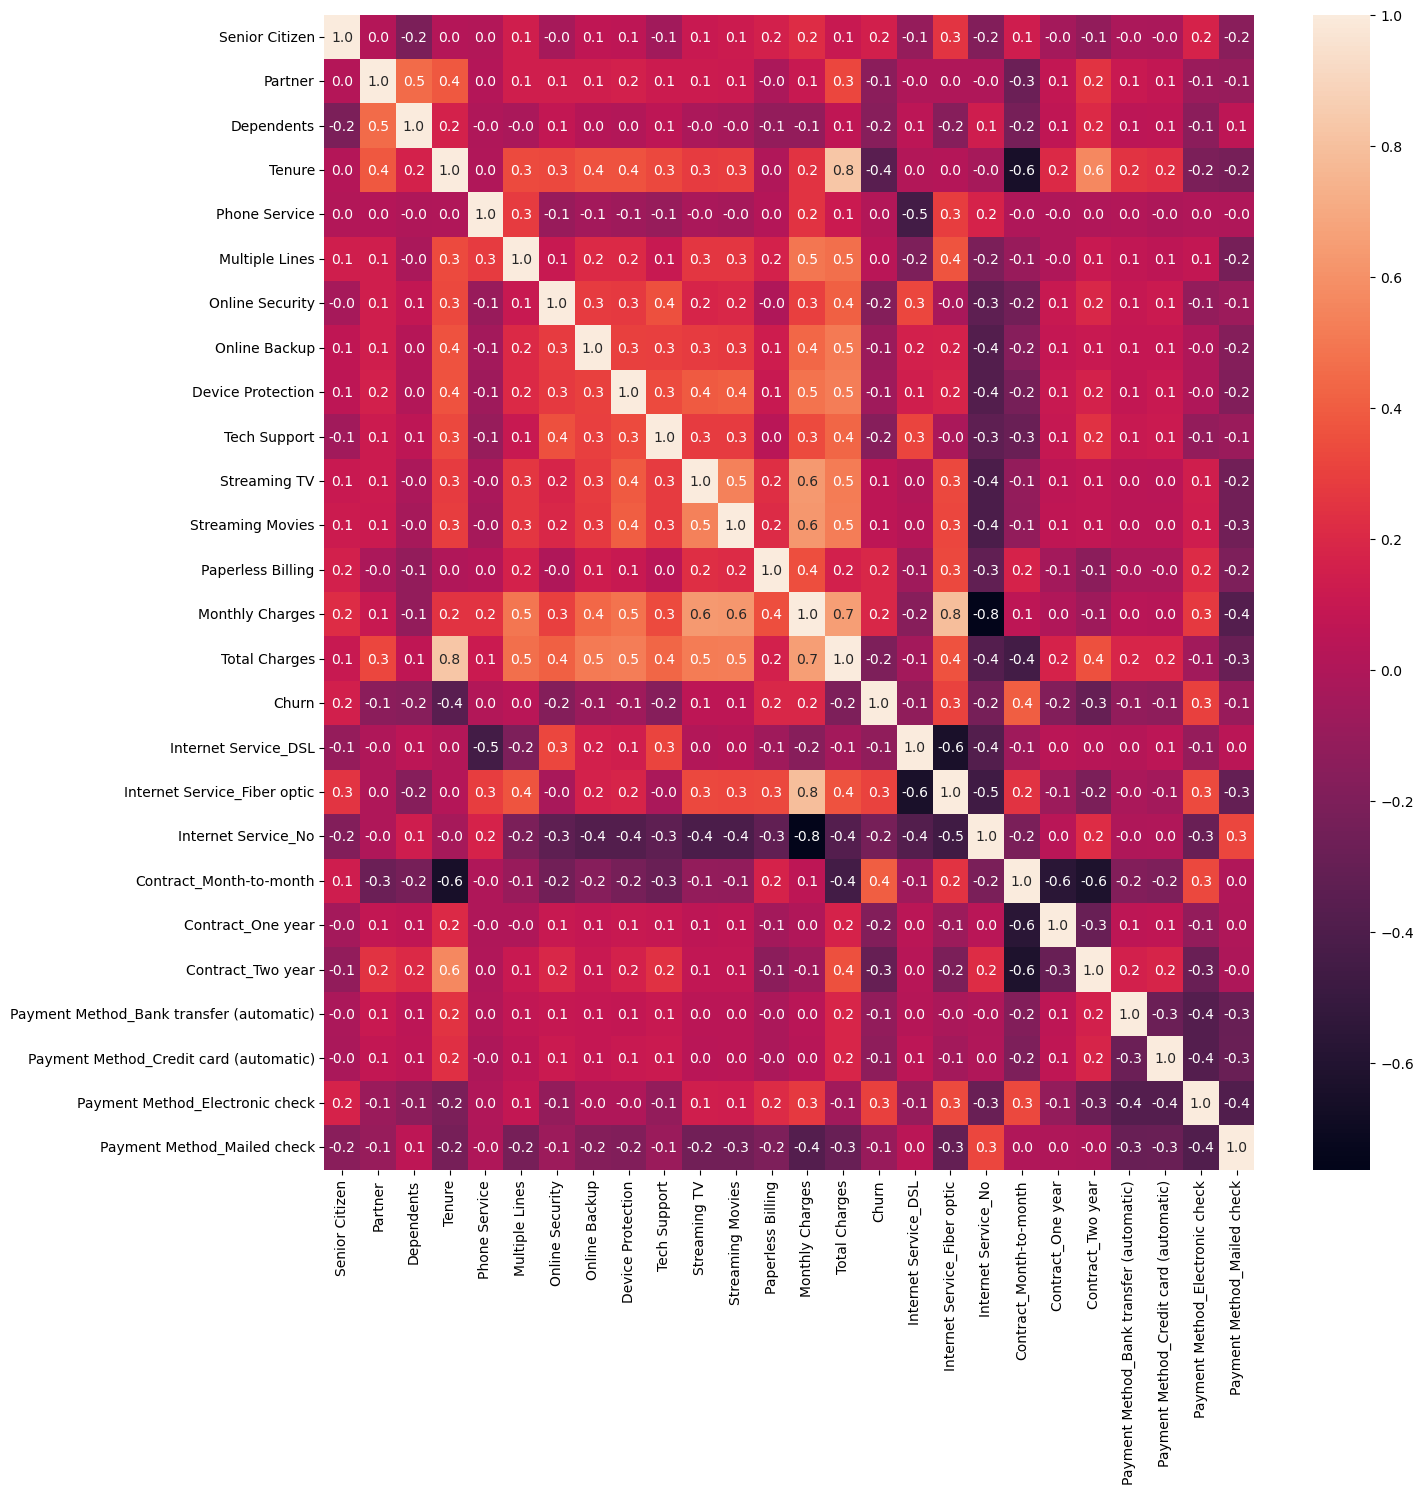

In [19]:
# Create a correlation heatmap
corr_mtx = df.corr()

plt.figure(figsize = (15,15))
sns.heatmap(corr_mtx, annot=True, fmt = ".1f")
plt.show()

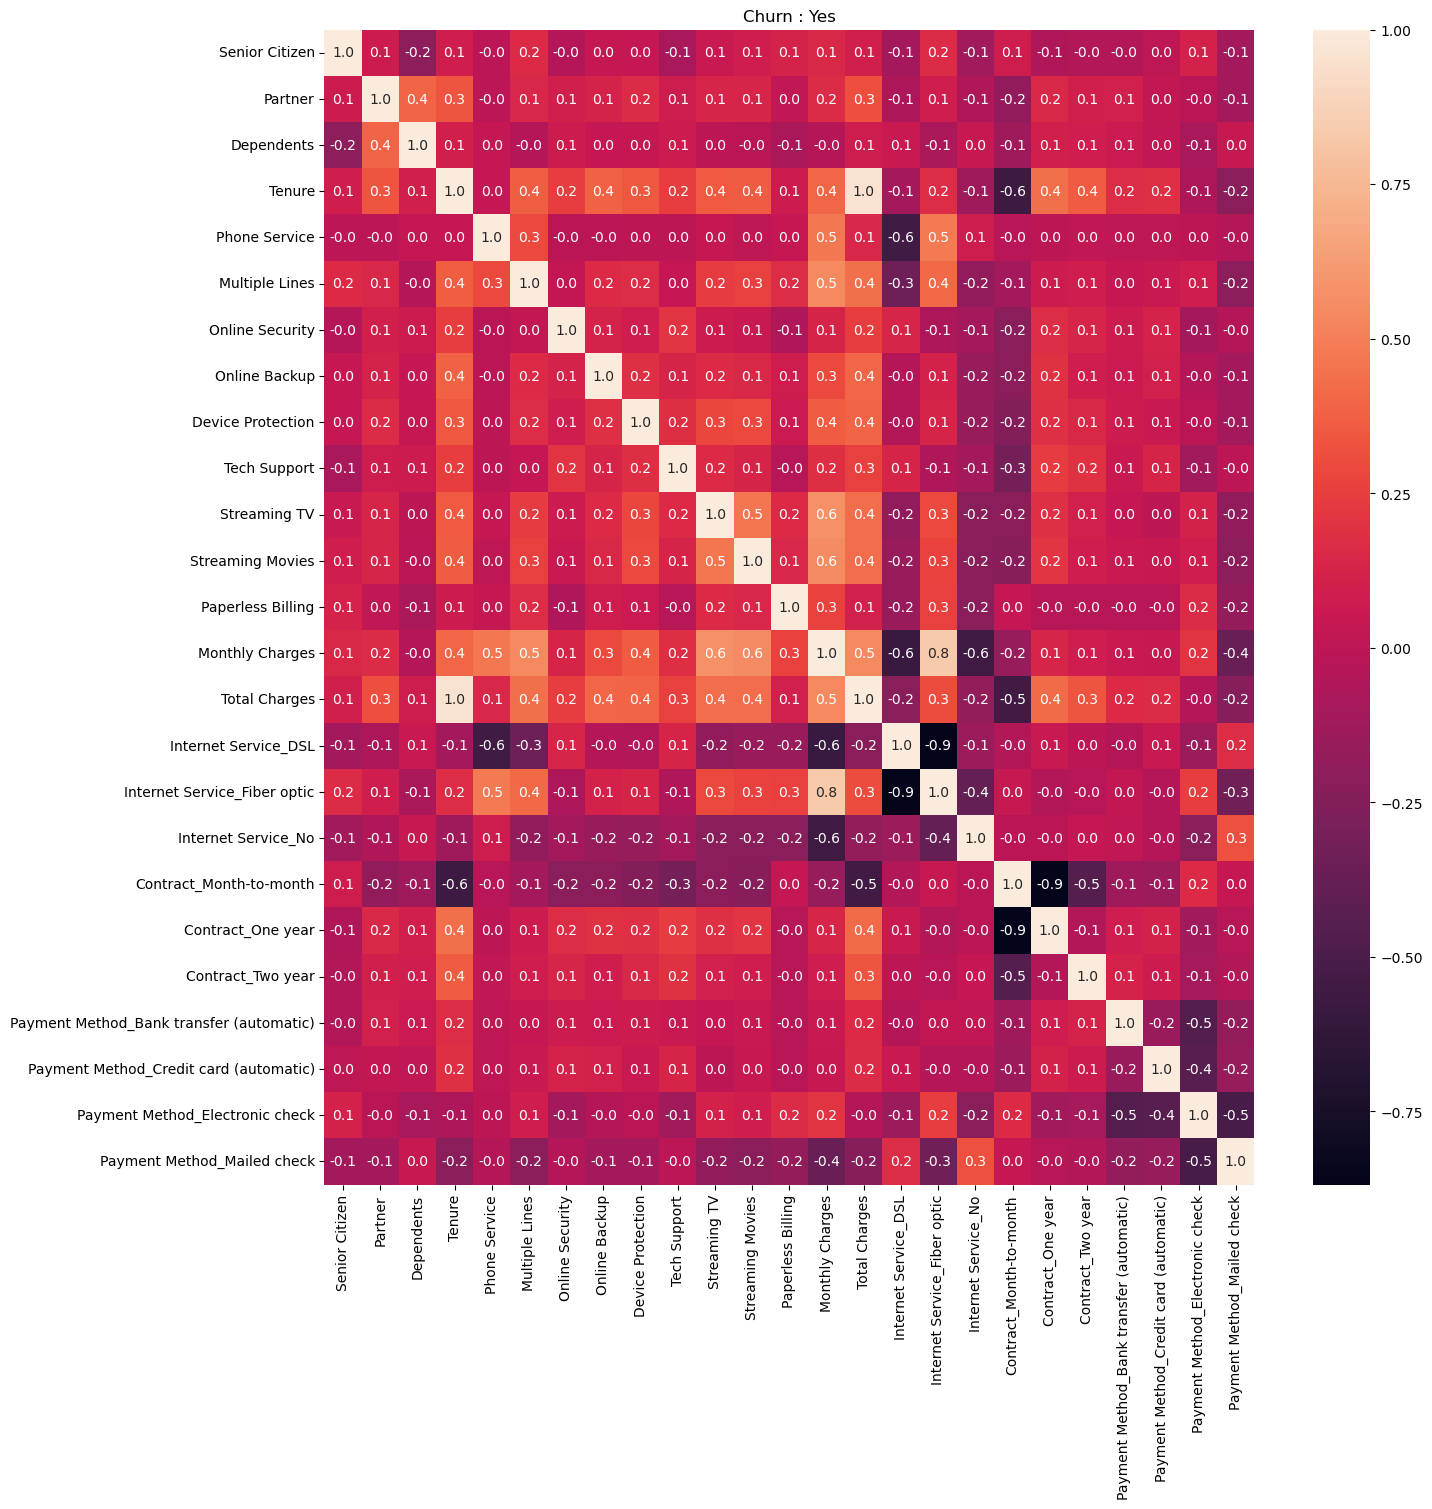

In [20]:
# In addition, create heatmaps for each churn variant.
yeschurn = df[df["Churn"] == True].drop("Churn", axis = 1).corr()
plt.figure(figsize = (15,15))
sns.heatmap(yeschurn, annot=True, fmt = ".1f")
plt.title("Churn : Yes")
plt.show()

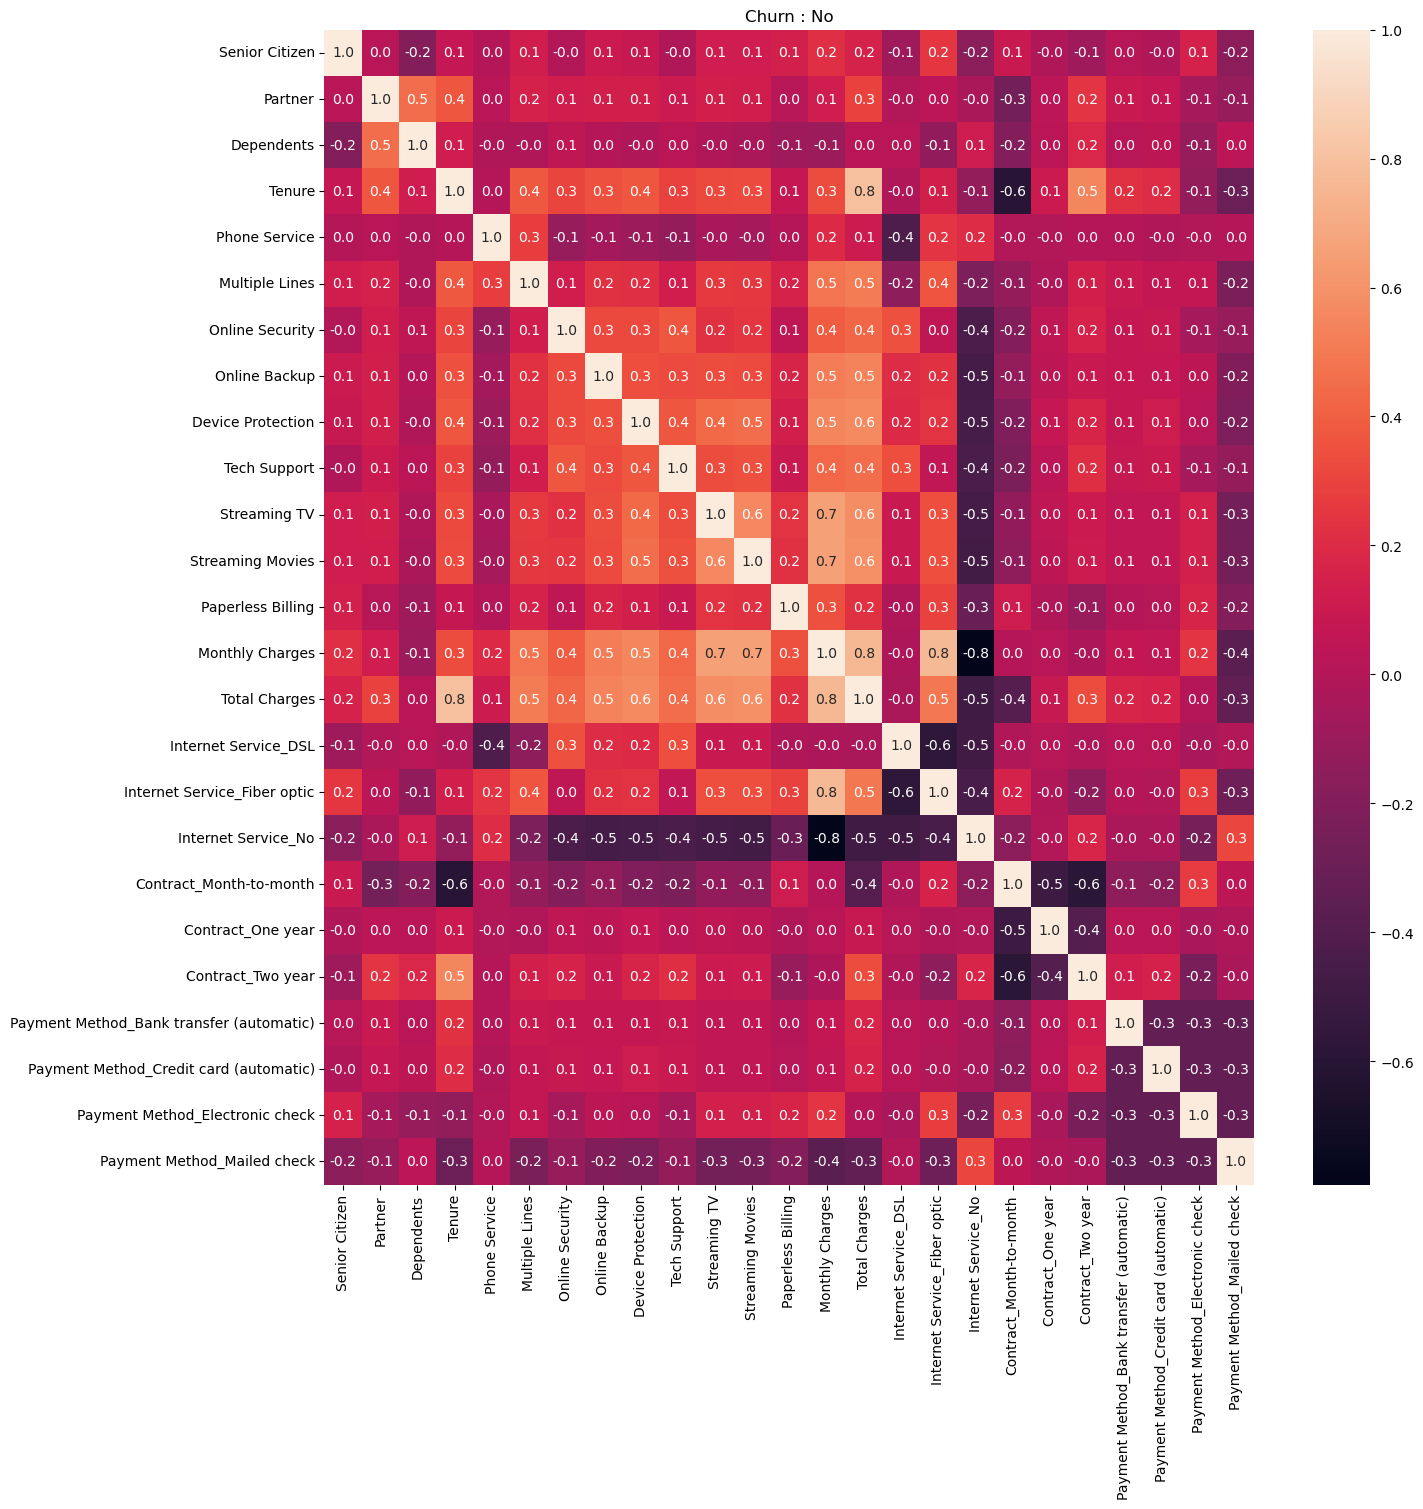

In [21]:
# In addition, create heatmaps for each churn variant.
nochurn = df[df["Churn"] == False].drop("Churn", axis = 1).corr()
plt.figure(figsize = (15,15))
sns.heatmap(nochurn, annot=True, fmt = ".1f")
plt.title("Churn : No")
plt.show()

# Model: Neural Network
Here I will make the NN Model

In [22]:
# For a neural network, the input needs to be numbers. 
df = df.astype(float)

In [23]:
# We'll need to save both X and y values onto their respective tensors.
X_tensor = torch.tensor(df.drop("Churn", axis = 1).values, dtype=torch.float32)
y_tensor = torch.tensor(df["Churn"].values, dtype=torch.float32).view(-1, 1)

In [24]:
print("X_tensor shape:", X_tensor.shape)  # should be (7032, 25)
print("y_tensor shape:", y_tensor.shape)  # should be (7032, 1)
print("Churn ratio:", y_tensor.sum().item() / y_tensor.shape[0])  # should be ~0.27 (based on earlier info)


X_tensor shape: torch.Size([7032, 25])
y_tensor shape: torch.Size([7032, 1])
Churn ratio: 0.26578498293515357


In [25]:
# Split the training data into testing
# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify = df["Churn"])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify = y_temp.numpy().flatten())


In [26]:
# Hyperparameters
batch_size = 100
lr = 1e-4
l2_lambda = 1e-1
num_epochs = 100

In [27]:
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)


C:\Users\manub\AppData\Local\Temp\ipykernel_38732\3405323041.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
C:\Users\manub\AppData\Local\Temp\ipykernel_38732\3405323041.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
C:\Users\manub\AppData\Local\Temp\ipykernel_38732\3405323041.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test), torch.te

In [28]:
class ChurnModel(nn.Module):
    def __init__(self, input_dim):
        super(ChurnModel, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_dim, 128)  # Input layer to first hidden layer
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)         # First hidden layer to second hidden layer
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(128, 1)          # Second hidden layer to output layer

        # Activation functions
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.3)

    def forward(self, x):
        # Pass input through the network
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))  # Apply ReLU after first layer
        #x = self.dropout(self.relu(self.bn2(self.fc2(x))))  # Apply ReLU after second layer
        x = self.fc3(x)  # Output using Sigmoid activation
        return x


In [29]:
model = ChurnModel(X_tensor.shape[1]).to(device)
pos_weight = torch.tensor([3.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = l2_lambda)


In [30]:
# Set up early stopping parameters
patience = 20
best_recall = 0.0
epochs_no_improve = 0

In [31]:
# Run the model
epoch_count = 0     # This is for the plot after this code block
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    epoch_count += 1
    running_loss = 0.0
    train_acc = 0.0
    total_samples = 0
    total_loss = 0.0  

    print(f"\nEpoch No. {epoch+1} out of {num_epochs}")
    with tqdm(total=len(trainloader)) as pbar:
        for idx, (data, labels) in enumerate(trainloader):
            data, labels = data.to(device), labels.to(device)

            # Forward Pass
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, labels)

            # Backpropagation and optimizer step
            loss.backward()
            optimizer.step()

            # Scale loss by batch size
            batch_loss = loss.item() * labels.size(0)
            total_loss += batch_loss

            # Binary classification accuracy
            probs = torch.sigmoid(pred)
            preds = (probs >= 0.5).float()
            correct = (preds == labels).sum().item()
            train_acc += correct
            total_samples += labels.size(0)


            pbar.set_postfix(
                Loss=f'{total_loss / total_samples:.4f}',  # Proper loss display
                Accuracy=f'{train_acc / total_samples:.4f}'
            )
            pbar.update(1)

    # Compute overall loss and accuracy
    train_loss = total_loss / total_samples  # Normalize loss
    train_acc = (train_acc / total_samples) * 100  # Convert to percentage

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
        
    # Validation updates
    model.eval()
    val_loss = 0.0
    val_acc = 0
    total_val_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  
        for data, labels in valloader:
            data, labels = data.to(device), labels.to(device)
            pred = model(data)
            loss = criterion(pred, labels)
            
            batch_loss = loss.item() * labels.size(0)  # Scale loss properly
            val_loss += batch_loss

            # Binary classification accuracy
            probs = torch.sigmoid(pred)
            preds = (probs >= 0.5).float()
            correct = (preds == labels).sum().item()
            val_acc += correct
            total_val_samples += labels.size(0)

            # Collect predictions and labels for recall calculation
            all_preds.extend(preds.cpu().numpy().astype(int).flatten())
            all_labels.extend(labels.cpu().numpy().astype(int).flatten())

    val_loss /= total_val_samples  # Normalize by total samples
    val_accuracy = (val_acc / total_val_samples) * 100

     # Calculate precision and recall using sklearn's recall_score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    pred_counts = Counter(all_preds)

    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | Dist: {pred_counts}")
    valid_losses.append(val_loss)
    valid_accuracies.append(val_accuracy)

    # **Early Stopping Check**
    if recall > best_recall:
        best_recall = recall
        epochs_no_improve = 0  # Reset counter
        torch.save(model, "temp_model.pth")  # Save best model
        print("Model improved, saving checkpoint.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    # **Trigger Early Stopping**
    if epochs_no_improve >= patience:
        print("Early stopping triggered. Training halted.")
        break



Epoch No. 1 out of 100


100%|██████████| 57/57 [00:00<00:00, 178.11it/s, Accuracy=0.4668, Loss=1.0336]


Precision: 0.3084 | Recall: 0.7701 | Dist: Counter({np.int64(1): 467, np.int64(0): 236})
Model improved, saving checkpoint.

Epoch No. 2 out of 100


100%|██████████| 57/57 [00:00<00:00, 407.37it/s, Accuracy=0.5022, Loss=1.0046]


Precision: 0.3215 | Recall: 0.7754 | Dist: Counter({np.int64(1): 451, np.int64(0): 252})
Model improved, saving checkpoint.

Epoch No. 3 out of 100


100%|██████████| 57/57 [00:00<00:00, 390.03it/s, Accuracy=0.5259, Loss=0.9961]


Precision: 0.3255 | Recall: 0.7433 | Dist: Counter({np.int64(1): 427, np.int64(0): 276})
No improvement for 1 epochs.

Epoch No. 4 out of 100


100%|██████████| 57/57 [00:00<00:00, 393.50it/s, Accuracy=0.5524, Loss=0.9908]


Precision: 0.3400 | Recall: 0.7273 | Dist: Counter({np.int64(1): 400, np.int64(0): 303})
No improvement for 2 epochs.

Epoch No. 5 out of 100


100%|██████████| 57/57 [00:00<00:00, 384.96it/s, Accuracy=0.5687, Loss=0.9852]


Precision: 0.3475 | Recall: 0.7433 | Dist: Counter({np.int64(1): 400, np.int64(0): 303})
No improvement for 3 epochs.

Epoch No. 6 out of 100


100%|██████████| 57/57 [00:00<00:00, 395.42it/s, Accuracy=0.5819, Loss=0.9801]


Precision: 0.3525 | Recall: 0.7540 | Dist: Counter({np.int64(1): 400, np.int64(0): 303})
No improvement for 4 epochs.

Epoch No. 7 out of 100


100%|██████████| 57/57 [00:00<00:00, 331.21it/s, Accuracy=0.5932, Loss=0.9751]


Precision: 0.3601 | Recall: 0.7433 | Dist: Counter({np.int64(1): 386, np.int64(0): 317})
No improvement for 5 epochs.

Epoch No. 8 out of 100


100%|██████████| 57/57 [00:00<00:00, 374.72it/s, Accuracy=0.5973, Loss=0.9709]


Precision: 0.3649 | Recall: 0.7219 | Dist: Counter({np.int64(1): 370, np.int64(0): 333})
No improvement for 6 epochs.

Epoch No. 9 out of 100


100%|██████████| 57/57 [00:00<00:00, 385.41it/s, Accuracy=0.5959, Loss=0.9668]


Precision: 0.3732 | Recall: 0.7005 | Dist: Counter({np.int64(0): 352, np.int64(1): 351})
No improvement for 7 epochs.

Epoch No. 10 out of 100


100%|██████████| 57/57 [00:00<00:00, 333.51it/s, Accuracy=0.6190, Loss=0.9622]


Precision: 0.3778 | Recall: 0.7112 | Dist: Counter({np.int64(1): 352, np.int64(0): 351})
No improvement for 8 epochs.

Epoch No. 11 out of 100


100%|██████████| 57/57 [00:00<00:00, 389.79it/s, Accuracy=0.6196, Loss=0.9580]


Precision: 0.3740 | Recall: 0.7219 | Dist: Counter({np.int64(1): 361, np.int64(0): 342})
No improvement for 9 epochs.

Epoch No. 12 out of 100


100%|██████████| 57/57 [00:00<00:00, 396.93it/s, Accuracy=0.6140, Loss=0.9531]


Precision: 0.3753 | Recall: 0.7487 | Dist: Counter({np.int64(1): 373, np.int64(0): 330})
No improvement for 10 epochs.

Epoch No. 13 out of 100


100%|██████████| 57/57 [00:00<00:00, 335.13it/s, Accuracy=0.6167, Loss=0.9492]

Precision: 0.3818 | Recall: 0.7166 | Dist: Counter({np.int64(0): 352, np.int64(1): 351})
No improvement for 11 epochs.

Epoch No. 14 out of 100



100%|██████████| 57/57 [00:00<00:00, 360.06it/s, Accuracy=0.6361, Loss=0.9446]


Precision: 0.3887 | Recall: 0.7380 | Dist: Counter({np.int64(1): 355, np.int64(0): 348})
No improvement for 12 epochs.

Epoch No. 15 out of 100


100%|██████████| 57/57 [00:00<00:00, 394.64it/s, Accuracy=0.6352, Loss=0.9402]


Precision: 0.3863 | Recall: 0.7540 | Dist: Counter({np.int64(1): 365, np.int64(0): 338})
No improvement for 13 epochs.

Epoch No. 16 out of 100


100%|██████████| 57/57 [00:00<00:00, 236.68it/s, Accuracy=0.6354, Loss=0.9363]


Precision: 0.3908 | Recall: 0.7754 | Dist: Counter({np.int64(1): 371, np.int64(0): 332})
No improvement for 14 epochs.

Epoch No. 17 out of 100


100%|██████████| 57/57 [00:00<00:00, 173.78it/s, Accuracy=0.6398, Loss=0.9326]


Precision: 0.3939 | Recall: 0.7647 | Dist: Counter({np.int64(1): 363, np.int64(0): 340})
No improvement for 15 epochs.

Epoch No. 18 out of 100


100%|██████████| 57/57 [00:00<00:00, 124.11it/s, Accuracy=0.6357, Loss=0.9283]


Precision: 0.3971 | Recall: 0.7326 | Dist: Counter({np.int64(0): 358, np.int64(1): 345})
No improvement for 16 epochs.

Epoch No. 19 out of 100


100%|██████████| 57/57 [00:00<00:00, 161.75it/s, Accuracy=0.6414, Loss=0.9247]


Precision: 0.4023 | Recall: 0.7380 | Dist: Counter({np.int64(0): 360, np.int64(1): 343})
No improvement for 17 epochs.

Epoch No. 20 out of 100


100%|██████████| 57/57 [00:00<00:00, 187.11it/s, Accuracy=0.6434, Loss=0.9205]


Precision: 0.4052 | Recall: 0.7540 | Dist: Counter({np.int64(0): 355, np.int64(1): 348})
No improvement for 18 epochs.

Epoch No. 21 out of 100


100%|██████████| 57/57 [00:00<00:00, 190.09it/s, Accuracy=0.6555, Loss=0.9160]


Precision: 0.3989 | Recall: 0.7914 | Dist: Counter({np.int64(1): 371, np.int64(0): 332})
Model improved, saving checkpoint.

Epoch No. 22 out of 100


100%|██████████| 57/57 [00:00<00:00, 124.84it/s, Accuracy=0.6469, Loss=0.9138]


Precision: 0.4164 | Recall: 0.7594 | Dist: Counter({np.int64(0): 362, np.int64(1): 341})
No improvement for 1 epochs.

Epoch No. 23 out of 100


100%|██████████| 57/57 [00:00<00:00, 121.96it/s, Accuracy=0.6585, Loss=0.9103]


Precision: 0.4160 | Recall: 0.7807 | Dist: Counter({np.int64(0): 352, np.int64(1): 351})
No improvement for 2 epochs.

Epoch No. 24 out of 100


100%|██████████| 57/57 [00:00<00:00, 150.32it/s, Accuracy=0.6526, Loss=0.9065]


Precision: 0.4232 | Recall: 0.7807 | Dist: Counter({np.int64(0): 358, np.int64(1): 345})
No improvement for 3 epochs.

Epoch No. 25 out of 100


100%|██████████| 57/57 [00:00<00:00, 116.18it/s, Accuracy=0.6635, Loss=0.9038]


Precision: 0.4195 | Recall: 0.7807 | Dist: Counter({np.int64(0): 355, np.int64(1): 348})
No improvement for 4 epochs.

Epoch No. 26 out of 100


100%|██████████| 57/57 [00:00<00:00, 119.66it/s, Accuracy=0.6574, Loss=0.9004]


Precision: 0.4312 | Recall: 0.7540 | Dist: Counter({np.int64(0): 376, np.int64(1): 327})
No improvement for 5 epochs.

Epoch No. 27 out of 100


100%|██████████| 57/57 [00:00<00:00, 100.52it/s, Accuracy=0.6651, Loss=0.8974]


Precision: 0.4311 | Recall: 0.7701 | Dist: Counter({np.int64(0): 369, np.int64(1): 334})
No improvement for 6 epochs.

Epoch No. 28 out of 100


100%|██████████| 57/57 [00:00<00:00, 117.26it/s, Accuracy=0.6631, Loss=0.8944]


Precision: 0.4473 | Recall: 0.7487 | Dist: Counter({np.int64(0): 390, np.int64(1): 313})
No improvement for 7 epochs.

Epoch No. 29 out of 100


100%|██████████| 57/57 [00:00<00:00, 141.61it/s, Accuracy=0.6654, Loss=0.8915]


Precision: 0.4282 | Recall: 0.7807 | Dist: Counter({np.int64(0): 362, np.int64(1): 341})
No improvement for 8 epochs.

Epoch No. 30 out of 100


100%|██████████| 57/57 [00:00<00:00, 108.93it/s, Accuracy=0.6677, Loss=0.8888]


Precision: 0.4323 | Recall: 0.8021 | Dist: Counter({np.int64(0): 356, np.int64(1): 347})
Model improved, saving checkpoint.

Epoch No. 31 out of 100


100%|██████████| 57/57 [00:00<00:00, 127.62it/s, Accuracy=0.6716, Loss=0.8864]


Precision: 0.4324 | Recall: 0.7861 | Dist: Counter({np.int64(0): 363, np.int64(1): 340})
No improvement for 1 epochs.

Epoch No. 32 out of 100


100%|██████████| 57/57 [00:00<00:00, 103.31it/s, Accuracy=0.6702, Loss=0.8833]


Precision: 0.4494 | Recall: 0.7594 | Dist: Counter({np.int64(0): 387, np.int64(1): 316})
No improvement for 2 epochs.

Epoch No. 33 out of 100


100%|██████████| 57/57 [00:00<00:00, 118.87it/s, Accuracy=0.6818, Loss=0.8814]


Precision: 0.4336 | Recall: 0.7861 | Dist: Counter({np.int64(0): 364, np.int64(1): 339})
No improvement for 3 epochs.

Epoch No. 34 out of 100


100%|██████████| 57/57 [00:00<00:00, 110.76it/s, Accuracy=0.6743, Loss=0.8793]


Precision: 0.4551 | Recall: 0.7594 | Dist: Counter({np.int64(0): 391, np.int64(1): 312})
No improvement for 4 epochs.

Epoch No. 35 out of 100


100%|██████████| 57/57 [00:00<00:00, 94.37it/s, Accuracy=0.6807, Loss=0.8770] 


Precision: 0.4465 | Recall: 0.7807 | Dist: Counter({np.int64(0): 376, np.int64(1): 327})
No improvement for 5 epochs.

Epoch No. 36 out of 100


100%|██████████| 57/57 [00:00<00:00, 100.78it/s, Accuracy=0.6869, Loss=0.8746]


Precision: 0.4398 | Recall: 0.7807 | Dist: Counter({np.int64(0): 371, np.int64(1): 332})
No improvement for 6 epochs.

Epoch No. 37 out of 100


100%|██████████| 57/57 [00:00<00:00, 119.12it/s, Accuracy=0.6875, Loss=0.8731]


Precision: 0.4411 | Recall: 0.7807 | Dist: Counter({np.int64(0): 372, np.int64(1): 331})
No improvement for 7 epochs.

Epoch No. 38 out of 100


100%|██████████| 57/57 [00:00<00:00, 134.74it/s, Accuracy=0.6868, Loss=0.8702]


Precision: 0.4520 | Recall: 0.7807 | Dist: Counter({np.int64(0): 380, np.int64(1): 323})
No improvement for 8 epochs.

Epoch No. 39 out of 100


100%|██████████| 57/57 [00:00<00:00, 115.86it/s, Accuracy=0.6828, Loss=0.8696]


Precision: 0.4520 | Recall: 0.7807 | Dist: Counter({np.int64(0): 380, np.int64(1): 323})
No improvement for 9 epochs.

Epoch No. 40 out of 100


100%|██████████| 57/57 [00:00<00:00, 92.89it/s, Accuracy=0.6921, Loss=0.8667]


Precision: 0.4489 | Recall: 0.7754 | Dist: Counter({np.int64(0): 380, np.int64(1): 323})
No improvement for 10 epochs.

Epoch No. 41 out of 100


100%|██████████| 57/57 [00:00<00:00, 145.90it/s, Accuracy=0.6939, Loss=0.8654]


Precision: 0.4444 | Recall: 0.7701 | Dist: Counter({np.int64(0): 379, np.int64(1): 324})
No improvement for 11 epochs.

Epoch No. 42 out of 100


100%|██████████| 57/57 [00:00<00:00, 148.28it/s, Accuracy=0.6919, Loss=0.8636]


Precision: 0.4444 | Recall: 0.7914 | Dist: Counter({np.int64(0): 370, np.int64(1): 333})
No improvement for 12 epochs.

Epoch No. 43 out of 100


100%|██████████| 57/57 [00:00<00:00, 153.77it/s, Accuracy=0.6992, Loss=0.8627]


Precision: 0.4475 | Recall: 0.7754 | Dist: Counter({np.int64(0): 379, np.int64(1): 324})
No improvement for 13 epochs.

Epoch No. 44 out of 100


100%|██████████| 57/57 [00:00<00:00, 149.95it/s, Accuracy=0.7019, Loss=0.8603]


Precision: 0.4479 | Recall: 0.7807 | Dist: Counter({np.int64(0): 377, np.int64(1): 326})
No improvement for 14 epochs.

Epoch No. 45 out of 100


100%|██████████| 57/57 [00:00<00:00, 119.58it/s, Accuracy=0.6946, Loss=0.8599]


Precision: 0.4625 | Recall: 0.7594 | Dist: Counter({np.int64(0): 396, np.int64(1): 307})
No improvement for 15 epochs.

Epoch No. 46 out of 100


100%|██████████| 57/57 [00:00<00:00, 136.04it/s, Accuracy=0.7010, Loss=0.8573]


Precision: 0.4589 | Recall: 0.7754 | Dist: Counter({np.int64(0): 387, np.int64(1): 316})
No improvement for 16 epochs.

Epoch No. 47 out of 100


100%|██████████| 57/57 [00:00<00:00, 112.66it/s, Accuracy=0.7024, Loss=0.8565]


Precision: 0.4598 | Recall: 0.7647 | Dist: Counter({np.int64(0): 392, np.int64(1): 311})
No improvement for 17 epochs.

Epoch No. 48 out of 100


100%|██████████| 57/57 [00:00<00:00, 107.38it/s, Accuracy=0.6999, Loss=0.8550]


Precision: 0.4762 | Recall: 0.7487 | Dist: Counter({np.int64(0): 409, np.int64(1): 294})
No improvement for 18 epochs.

Epoch No. 49 out of 100


100%|██████████| 57/57 [00:00<00:00, 130.83it/s, Accuracy=0.7065, Loss=0.8543]


Precision: 0.4686 | Recall: 0.7594 | Dist: Counter({np.int64(0): 400, np.int64(1): 303})
No improvement for 19 epochs.

Epoch No. 50 out of 100


100%|██████████| 57/57 [00:00<00:00, 126.07it/s, Accuracy=0.7052, Loss=0.8528]


Precision: 0.4669 | Recall: 0.7540 | Dist: Counter({np.int64(0): 401, np.int64(1): 302})
No improvement for 20 epochs.
Early stopping triggered. Training halted.


In [32]:
model = torch.load("temp_model.pth", weights_only = False)

In [33]:
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        y_true.append(labels)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        predicted = (probs >= 0.5).float()
        y_pred.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

model_accuracy = 100 * correct / total

print(f'Accuracy: {model_accuracy} %')

Accuracy: 69.0340909090909 %


In [34]:
from sklearn.metrics import classification_report

y_true = torch.cat(y_true).cpu().numpy().astype(int)
y_pred = torch.cat(y_pred).cpu().numpy().astype(int)
    
# Generating the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.62      0.75       517
           1       0.46      0.88      0.60       187

    accuracy                           0.69       704
   macro avg       0.70      0.75      0.67       704
weighted avg       0.81      0.69      0.71       704



In [36]:
recall_score(y_true, y_pred)

0.8770053475935828

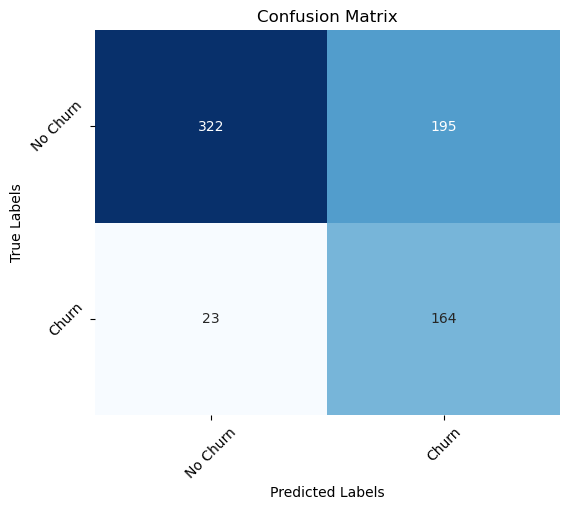

In [35]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = ["No Churn", "Churn"]

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=False)

plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()